# Proyecto: Ajuste polinomial de datos de temperatura de México

**Materia.** Métodos Matemáticos Computacionales para Ciencia de Datos

**Alumno.** Martínez Ostoa Néstor 

**Fecha.** 1 de noviembre del 2020

In [505]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## DataCollector
Clase encargada de recolectar los datos.

**Entradas:** *collect_data()*
- Año (int): año con el que se desea comenzar a recolectar datos. 
- Meses (int): número de meses que se desea recolectar datos comenzando desde el año inicial. 
- Entidad (string): nombre de la entidad federal solicitada

**Salida:**
- data_arrays (list(np.array)): lista de matrices $B$ (cada una de ellas representa la temperatura para un mes dado de una entidad dada en un año dado.)

In [506]:
class DataCollector:
    def __init__(self, year, months, entity):
        self.year = year
        self.months = months
        self.entity = entity
    
    def csvs_to_read(self):
        num_csvs, extra_months = 1, 0
        if self.months > 12:
            if self.months % 12 == 0:
                num_csvs = self.months / 12
            else:
                extra_months = self.months % 12
                num_csvs = self.months // 12 + 1
        elif self.months < 12:
            extra_months = self.months % 12

        return (int(num_csvs), extra_months)
    
    def collect_data(self):
        (num_csvs, extra_months) = self.csvs_to_read()
        data_arrays = []
        for i in range(self.year, self.year + num_csvs):
            df = pd.read_csv('datos/' + str(i) + 'Tmed.csv')
            arr = self.data_array(df, self.entity)
            if i == self.year + num_csvs - 1 and extra_months > 0:
                arr = arr[0:extra_months]
            data_arrays.append(np.array(arr))
        return data_arrays

    def data_array(self, dataframe, entity):
        for values in dataframe.values:
            if values[0] == entity:
                return values[1:-1]
    
    def visualize_data_array(self, data_arrays):
        for arr in data_arrays:
            print(arr)

## MatrixBuilder
Clase encargada de construir la matriz $A$ y las matrices $B$ para cada año que se introduce.

**Entrada:** *build_matrixes()*
- data_arrays (list(np.array)): lista de matrices $B$ (cada una de ellas representa la temperatura para un mes dado de una entidad dada en un año dado.)

**Salida:**
- matrixes (tuple(list, list)): tupla que tiene como primer elemento a la matriz $A$ y como segundo elemento una lista de matrices $B$ (una para cada año).

In [507]:
class MatrixBuilder:
    def __init__(self, temperatures, degree):
        self.temperatures = temperatures
        self.degree = degree

    def build_A(self):
        X = list(range(1,13))
        A = []
        for x in X:
            l = []
            for i in range(self.degree, 0, -1):
                l.append(x ** i)
            l.append(1)
            A.append(l)
        return A 

    def build_matrixes(self):
        Bs = [array for array in self.temperatures]
        A = np.array(self.build_A())
        return (A, Bs)

## PolinomialAproximator

Clase encargada de aproximar polinomios. Es decir, para cada matriz $B$ que reciba, esta entregara el polinomio aproximado utilizando el método de Cholesky. Dicho procedimiento es el siguiente: $$Ax = b$$ $$A^TAx = A^Tb$$
Una vez hecho este producto, encontramos la factorización de Cholesky a partir de la matriz $A^T \cdot A$ $$A^T A = LL^T$$
Posteriormente, resolvemos el siguietne sistema de ecuaciones $$Ly = A^T b$$ 
Finalmente, resolvemos el sistema siguiente para obtener los coeficientes de nuestro polinomio: $$L^Tx = y$$

**Entrada :** *build_coefficients()*
- matrixes (tuple(list, list)): tupla que tiene como primer elemento a la matriz $A$ y como segundo elemento una lista de matrices $B$ (una para cada año).

**Salida :**
- coeffs (list) : lista de coeficientes para un par $A$ y $b$

In [508]:
class PolinomialAproximator:
    def __init__(self, A, Bs):
        self.A = A
        self.Bs = Bs
    
    def build_coefficients(self):
        coeffs = []
        L = np.linalg.cholesky(np.matmul(self.A.T, self.A))
        for b in self.Bs:
            b = [x for x in b]
            b = np.array(b)
            y = np.linalg.solve(L, np.matmul(self.A.T, b))
            x = np.linalg.solve(L.T, y)
            coeffs.append(x)
        return coeffs

## PolinomialGrouper

Esta clase se encarga de reducir una lista de polinomios en solo un polinomio. Lo hace sacando la suma de los elementos de los polinomios y después los divide entre su longitud, por lo que se obtiene un promedio de la suma de los coeficientes de cada elemento del polinomio. Es decir, si recibimos una lista de dos polinomios del mismo grado, esta clase regresara un polinomio final como el promedio de los elementos de los dos polinomios recibidos.

**Entrada :** *process_coeffs()*
- coeffs (list) : lista de coeficientes para cada vector $B$
- final_polinomial_coeff (list) : lista de coeficientes del polinomio final ajustado

In [509]:
class PolinomialGrouper:
    def __init__(self, coefficients):
        self.coefficients = coefficients
    
    def sum_coeff_col(self, col_index):
        coeff_col = 0
        for coeff in self.coefficients:
            for i in range(len(coeff)):
                if i == col_index:
                    coeff_col += coeff[i]
        return coeff_col / len(self.coefficients)

    def process_coeffs(self):
        final_polinomial_coefficient = []
        for i in range(len(self.coefficients[0])):
            final_polinomial_coefficient.append(self.sum_coeff_col(i))
        return final_polinomial_coefficient

## ErrorCalculator

Clase encargada de calcular el error asociado a un vector $b$ (es decir, el vector de temperaturas conocidas para una entidad y año dado) comparado con una aproximación del vector $b$. El error lo calcula mediante la raíz de las diferencias entre el vector $b$ y $b_{aprox}$. 

**Entrada: ** *build_b()*
- final_polinomial_coefficient (list): lista de los coeficientes del polinomio ajustado.

**Salida :**
- error (float): error aproximado

In [510]:
class ErrorCalculator:
    def __init__(self, coefficients, Bs):
        self.coefficients = coefficients
        self.Bs = Bs

    def aproximate(self):
        degree = len(self.coefficients)
        aproximation = []
        for i in range(1, 13):
            l = []
            for j in range(degree):
                l.append(self.coefficients[degree-j-1] * (i ** j))
            aproximation.append(sum(l))
        return aproximation

    def build_b(self, col_index):
        b_avg = 0
        for b in self.Bs:
            for i in range(len(b)):
                if i == col_index:
                    b_avg += b[i]
        return b_avg / len(self.Bs)

    def aproximation_error(self):
        b = []
        for i in range(len(self.Bs[0])):
            b.append(self.build_b(i))
        b_aprox = np.array(self.aproximate())
        ap_error = ((b_aprox - b) / b) * 100
        return (b, b_aprox, sum(ap_error))

## Grapher

Clase encargada de graficar los resultados del ajuste polinomial.

**Entrada: ** *graph()*
- b (list): lista de las temperaturas registradas
- b_estimated (list): lista de las temperaturas predecidas mediante el polinomio ajustado
- title (string) : título de la gráfica

**Salida: **
- Gráfica solicitada

In [511]:
class Grapher:
    def __init__(self, b, b_estimated, title):
        self.b = b
        self.b_estimated = b_estimated
        self.title = title

    def graph(self):
        x = list(range(1,13))
        plt.plot(x, self.b, 'o')
        plt.plot(x, self.b_estimated)
        plt.xlabel('Mes')
        plt.ylabel('Temperatura ºC')
        plt.title(self.title)
        plt.show()

## Ajuste polinomial en funcionamiento

### Elección de entradas
1. Año 
2. Número de meses
3. Entidad

In [512]:
año = 2016
num_meses = 12
entidad = 'AGUASCALIENTES'

### Recolección de datos
Este proceso se hace llamando a la clase **DataCollector** y al mandar a llamar a *visualize_data_array* podemos ver las temperaturas deseadas.

In [513]:
dc = DataCollector(año, num_meses, entidad)
data_arrays = dc.collect_data()
dc.visualize_data_array(data_arrays)

[12.1 15.0 17.0 19.8 23.3 21.9 21.0 20.6 20.2 19.8 15.9 15.1]


### Construcción de vectores $b$ y matriz $A$
Este proceso se hace con la clase *MatrixBuilder* y seleccionando un grado del polinomio.

In [514]:
degree = 3
mb = MatrixBuilder(data_arrays, degree)
(A, Bs) = mb.build_matrixes()
print(A)
print(Bs)

[[   1    1    1    1]
 [   8    4    2    1]
 [  27    9    3    1]
 [  64   16    4    1]
 [ 125   25    5    1]
 [ 216   36    6    1]
 [ 343   49    7    1]
 [ 512   64    8    1]
 [ 729   81    9    1]
 [1000  100   10    1]
 [1331  121   11    1]
 [1728  144   12    1]]
[array([12.1, 15.0, 17.0, 19.8, 23.3, 21.9, 21.0, 20.6, 20.2, 19.8, 15.9,
       15.1], dtype=object)]


### Ajuste polinomial
Este proceso se realizar con la clase *PolinomialAproximator* y nos regresa una lista de coeficientes polinomiales para cada uno de los vectores $b$.

In [515]:
pa = PolinomialAproximator(A, Bs)
coefficients_list = pa.build_coefficients()
print(coefficients_list)

[array([ 0.01102046, -0.50193695,  5.08191438,  7.04343434])]


### Agrupación de polinomios
Este proceso se realiza con la clase *PolinomialGrouper* y nos regresa los coeficientes del polinomio final ajustado.

In [516]:
pg = PolinomialGrouper(coefficients_list)
final_coefficients = pg.process_coeffs()
print(final_coefficients)

[0.011020461020444308, -0.5019369519366136, 5.081914381912448, 7.043434343437067]


### Cálculo del error
Este proceso se hace con la clase **ErrorCalculator** la cual nos regresa el error calculado así como el vector $b$ estimado y el vector $b$ original. En caso de que hayamos elegido más de un año a analizar, el vector $b$ estará compuesto por el promedio de las temperaturas para un mes dado. Es decir, si tenemos datos de $2016$ y $2017$, el vector $b$ será uno tal que el elemento $0$ corresponderá con el promedio de las temperaturas para Enero del $2016$ y $2017$ para la entidad dada.

In [517]:
ec = ErrorCalculator(final_coefficients, Bs)
(b, b_aprox, error) = ec.aproximation_error()
print(b)
print("----")
print(b_aprox)
print("---")
print(error)

[12.1, 15.0, 17.0, 19.8, 23.3, 21.9, 21.0, 20.6, 20.2, 19.8, 15.9, 15.1]
----
[11.63443223 15.28767899 18.06929737 20.04541015 21.28214008 21.84560995
 21.8019425  21.21726052 20.15768676 18.68934399 16.87835498 14.79084249]
---
1.7930367806475171


### Obtención de gráficas


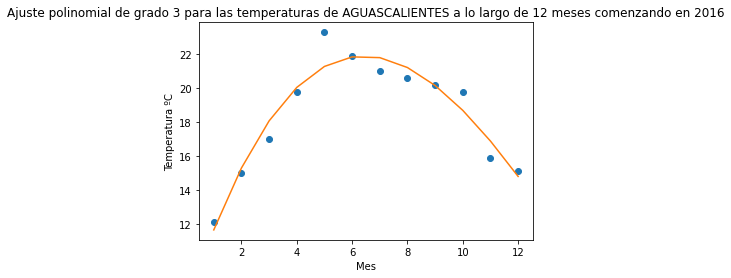

In [518]:
g = Grapher(b, b_aprox, f'Ajuste polinomial de grado {degree} para las temperaturas de {entidad} a lo largo de {num_meses} meses comenzando en {año}')
g.graph()

### Ejemplo más rápido y análisis mediante la clase Fitter

In [519]:
class Fitter:
    def __init__(self, year, months, entity, degree=3, verbose=False):
        self.year = year
        self.months = months
        self.entity = entity 
        self.degree = degree
        self.verbose = verbose
    
    def fit(self):
        dc = DataCollector(self.year, self.months, self.entity)
        data_arrays = dc.collect_data()

        mb = MatrixBuilder(data_arrays, self.degree)
        (A, Bs) = mb.build_matrixes()

        pa = PolinomialAproximator(A, Bs)
        coefficients_list = pa.build_coefficients()

        pg = PolinomialGrouper(coefficients_list)
        final_coefficients = pg.process_coeffs()

        ec = ErrorCalculator(final_coefficients, Bs)
        (b, b_aprox, error) = ec.aproximation_error()

        if self.verbose:
            print("Datos recolectados empezando por ", self.year, ": ", data_arrays)
            print("Matriz A:", A)
            print("Vectores b:", Bs)
            print("Lista de coeficientes", coefficients_list)
            print("Coeficientes del polinomio final", final_coefficients)
            print("b:", b)
            print("b estimada: ", b_aprox)
            print("error: ", error)

        g = Grapher(b, b_aprox, f'Ajuste polinomial de grado {self.degree} para las temperaturas de {self.entity} a lo largo de {self.months} meses comenzando en {self.year} con un error {error}')
        g.graph()

## Análisis
### Datos
Escogí los datos de la entidad *Aguascalientes* entre los años

Datos recolectados empezando por  2008 :  [array([13.1, 15.0, 15.5, 19.6, 21.3, 22.5, 19.1, 20.0, 19.1, 17.2, 14.0,
       12.9], dtype=object), array([13.7, 15.1, 17.3, 19.1, 21.7, 22.4, 20.3, 21.5, 20.4, 19.1, 14.8,
       13.2], dtype=object), array([11.4, 12.2, 15.3, 18.3, 21.4, 22.4, 19.9, 20.6, 20.8, 17.5, 15.0,
       12.7], dtype=object), array([12.8, 15.2, 17.9, 20.5, 22.4, 22.0, 21.3, 20.8, 19.4, 17.3, 15.2,
       14.1], dtype=object), array([12.9, 14.0, 17.7, 18.5, 21.5, 21.6, 19.7, 20.0, 19.0, 18.6, 15.8,
       14.4], dtype=object), array([13.4, 15.6, 15.8, 19.4, 21.5, 22.8, 20.4, 20.7, 20.1, 18.6, 16.1,
       13.4], dtype=object), array([12.4, 15.4, 17.5, 20.2, 20.8, 21.9, 20.1, 19.9, 19.5, 19.3, 14.4,
       13.7], dtype=object), array([13.9, 14.5, 15.3, 20.0, 20.4, 20.7, 19.5, 19.7, 19.6, 18.1, 17.1,
       13.6], dtype=object), array([12.1, 15.0, 17.0, 19.8, 23.3, 21.9, 21.0, 20.6, 20.2, 19.8, 15.9,
       15.1], dtype=object)]
Matriz A: [[        1         1        

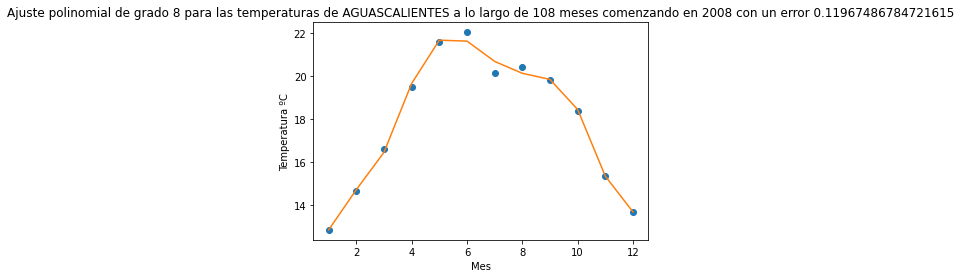

In [560]:
Fitter(2008, 12*9, 'AGUASCALIENTES', degree=8, verbose=True).fit()

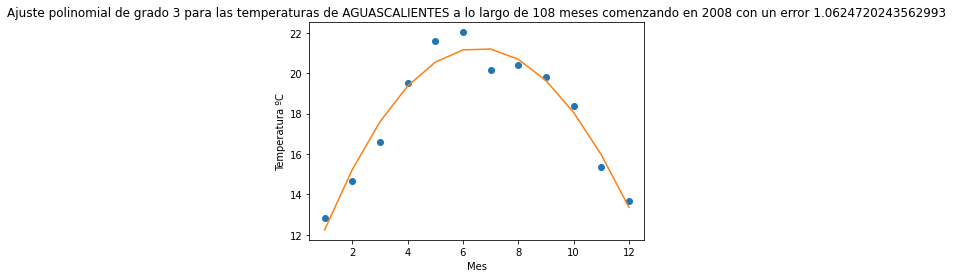

In [546]:
Fitter(2008, 12*9, 'AGUASCALIENTES', degree=3).fit()

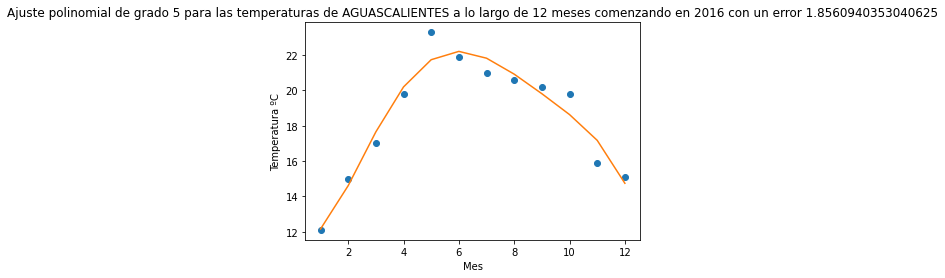

In [522]:
Fitter(2016, 12, 'AGUASCALIENTES', degree=5).fit()

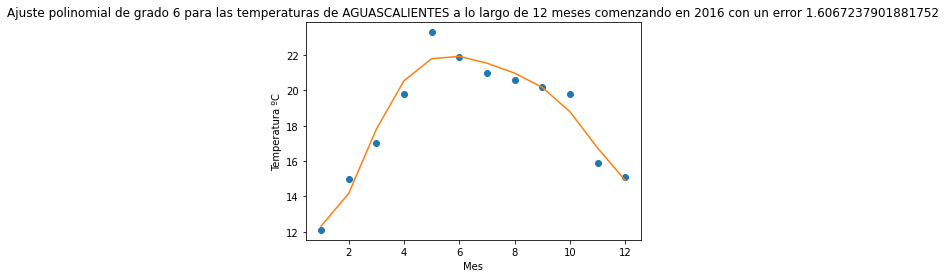

In [523]:
Fitter(2016, 12, 'AGUASCALIENTES', degree=6).fit()